# Return Behavior
This notebook investigates the return distribution for the S&P 500 returns and how it changes over time. This involves observing return distributions, estimation errors for expected return and standard deviation, and how the percentage of positive and negative returns change over time. At the end of the study, I investigate whether the percentage of positive returns is a useful signal for predicting future return behavior.

In [194]:
# File imports
import hurst
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf

# Import settings
plt.style.use('ggplot')

In [195]:
# Download the market data
data = yf.download('^GSPC', period='max', interval='1d', auto_adjust=True)['Close']

# Calculate the returns for different periods
data['Daily'] = data['^GSPC'].pct_change()
data['Monthly'] = data['^GSPC'].resample('ME').last().pct_change()
data['Yearly'] = data['^GSPC'].resample('YE').last().pct_change()

[*********************100%***********************]  1 of 1 completed


### Return Distributions
Below displays the summary statistics for each period and its associated distributions. This section only considers only the _full-period_ summaries. 

Daily Returns:
Positive Returns(%): 52.4119 | Negative Returns(%): 47.5881
count    24483.000000
mean         0.000310
std          0.011953
min         -0.204669
25%         -0.004550
50%          0.000494
75%          0.005475
max          0.166096
Name: Daily, dtype: float64
Monthly Returns:
Positive Returns(%): 58.9963 | Negative Returns(%): 41.0037
count    817.000000
mean       0.004797
std        0.053438
min       -0.299423
25%       -0.020624
50%        0.008833
75%        0.035271
max        0.391376
Name: Monthly, dtype: float64
Yearly Returns:
Positive Returns(%): 66.6667 | Negative Returns(%): 33.3333
count    69.000000
mean      0.071602
std       0.201613
min      -0.470665
25%      -0.065591
50%       0.107868
75%       0.233090
max       0.450222
Name: Yearly, dtype: float64


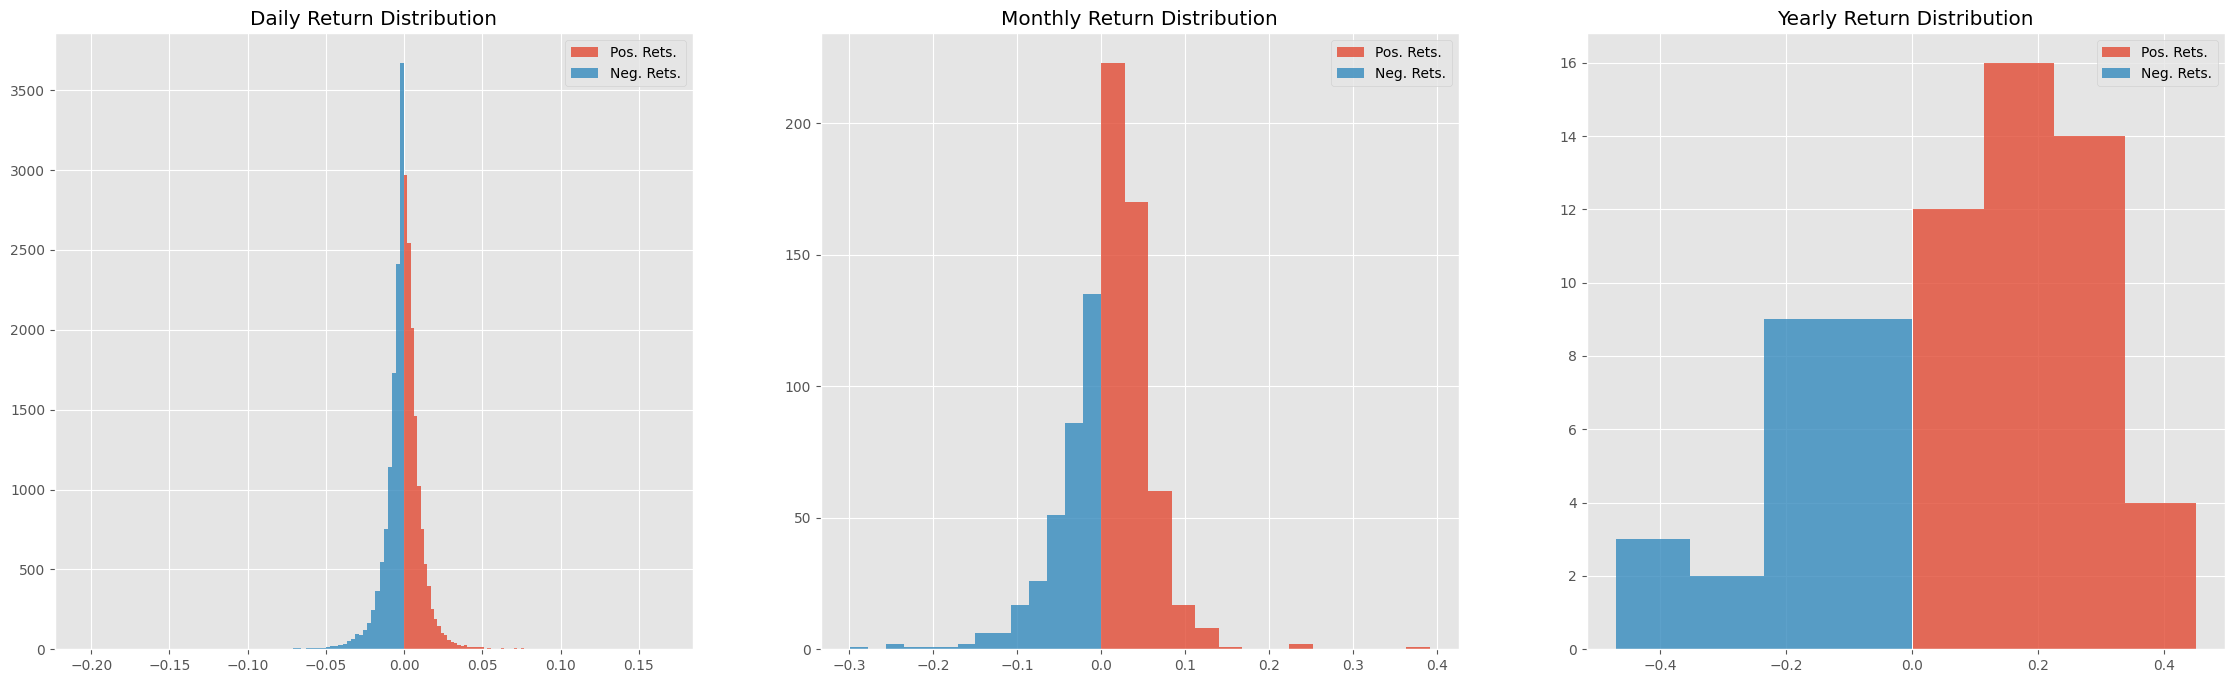

In [196]:
fig, axes = plt.subplots(1, 3, figsize=(28, 8))

# Determine the total % of positive and negative returns for each periodicity
ncol = 0
for col in data.columns:
    if col != '^GSPC':
        return_data = data[col].dropna()

        # Calculate the percentage of positive and negative returns
        pos_returns = return_data[return_data > 0]
        neg_returns = return_data[return_data <= 0]

        pos_pct = len(pos_returns) / len(return_data) * 100
        neg_pct = len(neg_returns) / len(return_data) * 100

        print(f'{col} Returns:')
        print(f'Positive Returns(%): {pos_pct:.4f} | Negative Returns(%): {neg_pct:.4f}')
        print(return_data.describe())

        bins = int(np.sqrt(len(return_data)) / 2)

        # Plot the distribution of returns
        axes[ncol].hist(pos_returns, bins=bins, alpha=0.8, label='Pos. Rets.')
        axes[ncol].hist(neg_returns, bins=bins, alpha=0.8, label='Neg. Rets.')
        axes[ncol].set_title(f'{col} Return Distribution')
        axes[ncol].legend()

        ncol += 1

# Display the plot
plt.show()

Observed above, all periods have a larger percentage of positive returns compared to negative returns (which makes intuitive sense). Given that the price of the S&P 500 has advanced since 1928, we would expect a larger number of positive returns. The more intersting observation is that as the time period increases, the percentage of positive returns also increases. One reason for this could be the association between time and smaller measurement intervals. The daily period yields a positive return percentage of 52.41%. Because there is a longer period in a monthly interval, the positive return percentage compounds over the period to yield a greater percentage than that of the shorter interval. This can also be observed extending to the annual interval.

### Estimating E(r) and $\sigma$
Below uses bootstrapping techniques to obtain sample estimates of the expected return and standard deviation over the various periods.

In [197]:
# Objective Function (expected return)
def expected_return(returns, idx):
    """
    * Calulates an estimated expected return based on historical
    * return data.
    *
    * returns: Full period returns.
    * idx: Index defining observations to calculate E(r) estimate.
    *      Used for bootstrap resampling.
    *
    * returns the sample mean (expected return)
    """

    return returns.loc[idx].mean()

# Objective Function (standard deviation)
def standard_deviation(returns, idx):
    """
    * Calulates an estimated standard deviation based on historical
    * return data.
    *
    * returns: Full period returns.
    * idx: Index defining observations to calculate sigma estimate.
    *      Used for bootstrap resampling.
    *
    * returns the sample sigma (standard deviation)
    """

    return returns.loc[idx].std()

Daily Expected Return Standard Error: 7.646477955179488e-05
Monthly Expected Return Standard Error: 0.0018531171812392634
Yearly Expected Return Standard Error: 0.02335319920078721


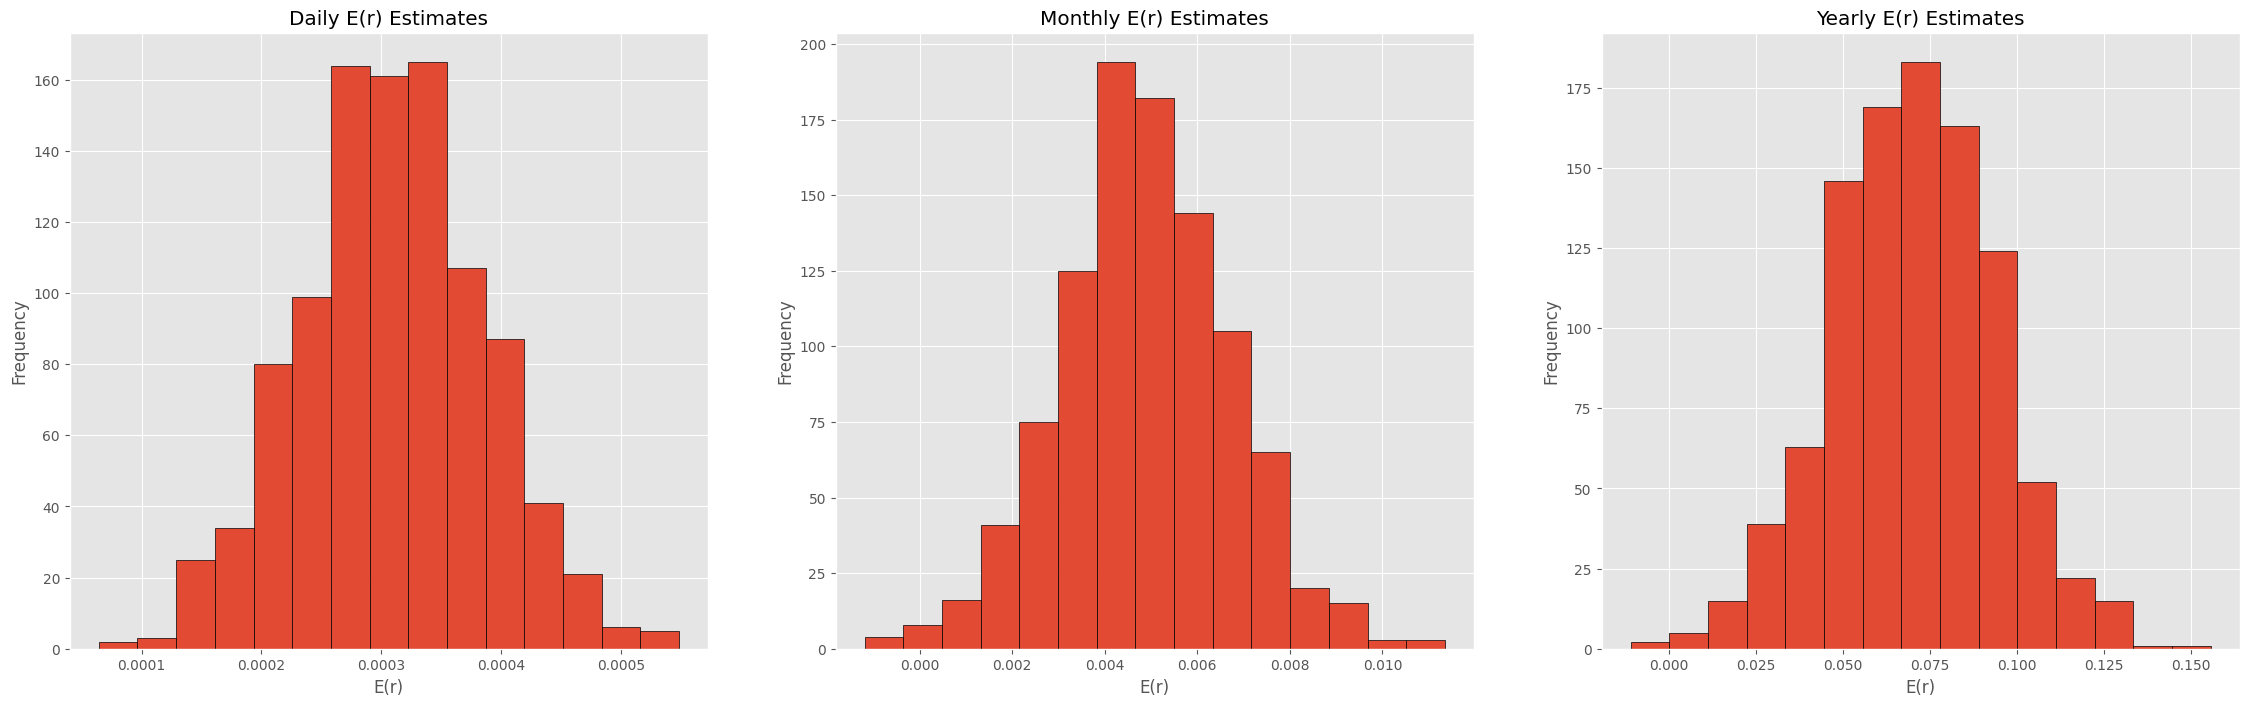

In [198]:
def bootstrapped_Er(func, data, replications=1000, seed=0):
    # Seed the random range
    rand_range = np.random.default_rng(seed)
    n = len(data)

    # Standard error estimates
    se_first, se_second = 0, 0

    # Initialize the expected return estimates to be zero
    er_estimates = np.zeros(replications)

    for i in range(replications):
        # Extract the index range
        idx = rand_range.choice(data.index, n, replace=True)

        # Estimate the expected return
        er_value = expected_return(data, idx)
        er_estimates[i] = er_value

        # Update the standard error parameters
        se_first += er_value
        se_second += er_value ** 2

    return np.sqrt(se_second / replications - (se_first / replications) ** 2), er_estimates

# Distribution plot variables
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
ncol = 0

# Process all return periods
for col in data.columns:
    if col != '^GSPC':
        # Extract the expected return estimates and standard errors
        er_standard_error, er_estimates = bootstrapped_Er(expected_return, data[col].dropna())

        print(f'{col} Expected Return Standard Error: {er_standard_error}')

        # Plot the estimates of the daily expected return
        axes[ncol].hist(er_estimates, bins=15, edgecolor='black')
        axes[ncol].set_title(f'{col} E(r) Estimates')
        axes[ncol].set_xlabel('E(r)')
        axes[ncol].set_ylabel('Frequency')

        ncol += 1

plt.show()

Above computes the E(r) estimates for the daily, monthly, and yearly periods. For a random sample from the population of daily returns from 1928 to current, we should expect the estimated daily E(r) to differ from the true E(r) by approximately 0.0000765 (0.00765%), on average. For a random sample from the population of monthly returns from 1928 to current, we should expect the estimated monthly E(r) to differ from the true E(r) by approximately 0.00185 (0.185%), on average. For a random sample from the population of annual returns from 1928 to current, we should expect the estimated annual E(r) to differ from the true E(r) by approximately 0.02335 (2.335%), on average.

Daily Standard Deviation Standard Error: 0.00016979395930253447
Monthly Standard Deviation Standard Error: 0.0028024287178336276
Yearly Standard Deviation Standard Error: 0.01709848761169222


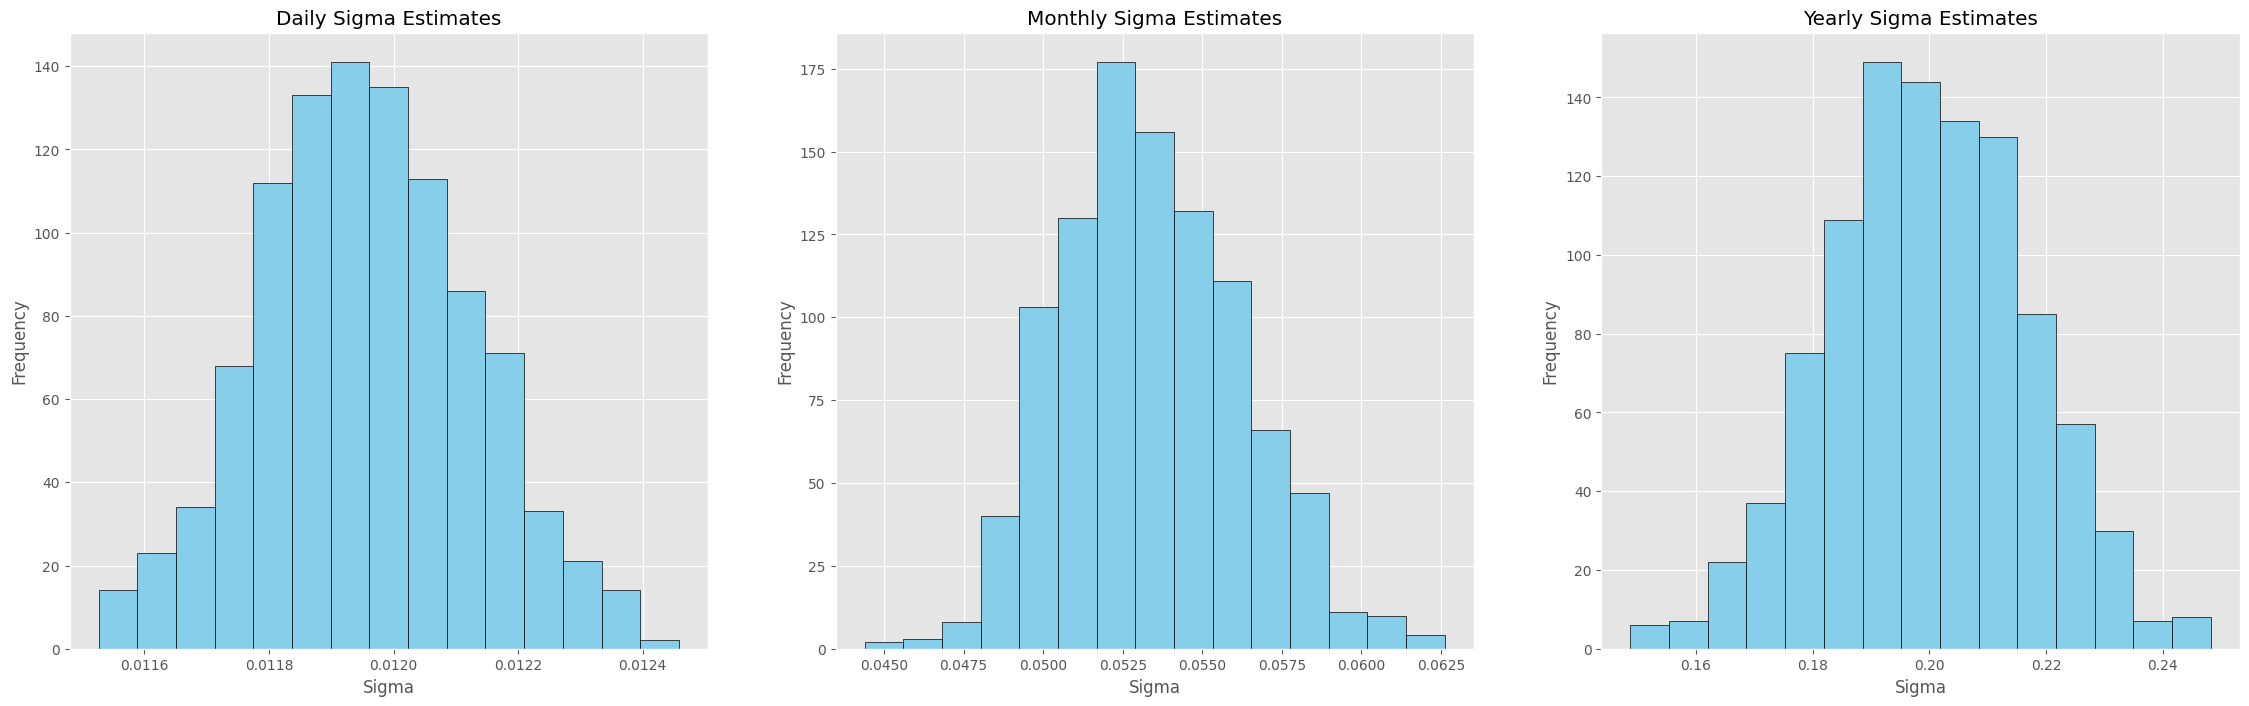

In [199]:
def bootstrapped_sd(func, data, replications=1000, seed=0):
    # Seed the random range
    rand_range = np.random.default_rng(seed)
    n = len(data)

    # Standard error estimates
    se_first, se_second = 0, 0

    # Initialize the expected return estimates to be zero
    sd_estimates = np.zeros(replications)

    for i in range(replications):
        # Extract the index range
        idx = rand_range.choice(data.index, n, replace=True)

        # Estimate the expected return
        sd_value = standard_deviation(data, idx)
        sd_estimates[i] = sd_value

        # Update the standard error parameters
        se_first += sd_value
        se_second += sd_value ** 2

    return np.sqrt(se_second / replications - (se_first / replications) ** 2), sd_estimates

# Distribution plot variables
fig, axes = plt.subplots(1, 3, figsize=(28, 8))
ncol = 0

# Process all periods
for col in data.columns:
    if col != '^GSPC':
        # Extract the standard deviation estimates and standard errors
        sd_standard_error, sd_estimates = bootstrapped_sd(standard_deviation, data[col])

        print(f'{col} Standard Deviation Standard Error: {sd_standard_error}')

        # Plot the estimates of the daily expected return
        axes[ncol].hist(sd_estimates, bins=15, edgecolor='black', color='skyblue')
        axes[ncol].set_title(f'{col} Sigma Estimates')
        axes[ncol].set_xlabel('Sigma')
        axes[ncol].set_ylabel('Frequency')

        ncol += 1

plt.show()

Above computes the standard deviation estimates for the daily, monthly, and yearly periods. For a random sample from the population of daily returns from 1928 to current, we should expect the estimated daily $\sigma$ to differ from the true $\sigma$ by approximately 0.0001698 (0.01698%), on average. For a random sample from the population of monthly returns from 1928 to current, we should expect the estimated monthly $\sigma$ to differ from the true $\sigma$ by approximately 0.00280 (0.280%), on average. For a random sample from the population of annual returns from 1928 to current, we should expect the estimated annual $\sigma$ to differ from the true $\sigma$ by approximately 0.017098 (1.7098%), on average.

### Return Percentages
The last method of observation is the rolling percentage of positive returns. A large percentage of positive returns suggests that investors are bidding up prices to potentially over-extended levels. A low percentage of positive returns suggests that investors are bidding down prices to low levels. By simple inspection, the process seems to be mean reverting. We investigate whether the levels of positive return percentages has predictive power. 

(Daily) Minimum Positive %: 37.3016
(Daily) Maximum Positive %: 63.0952
(Daily) Mean Positive %:     52.4097


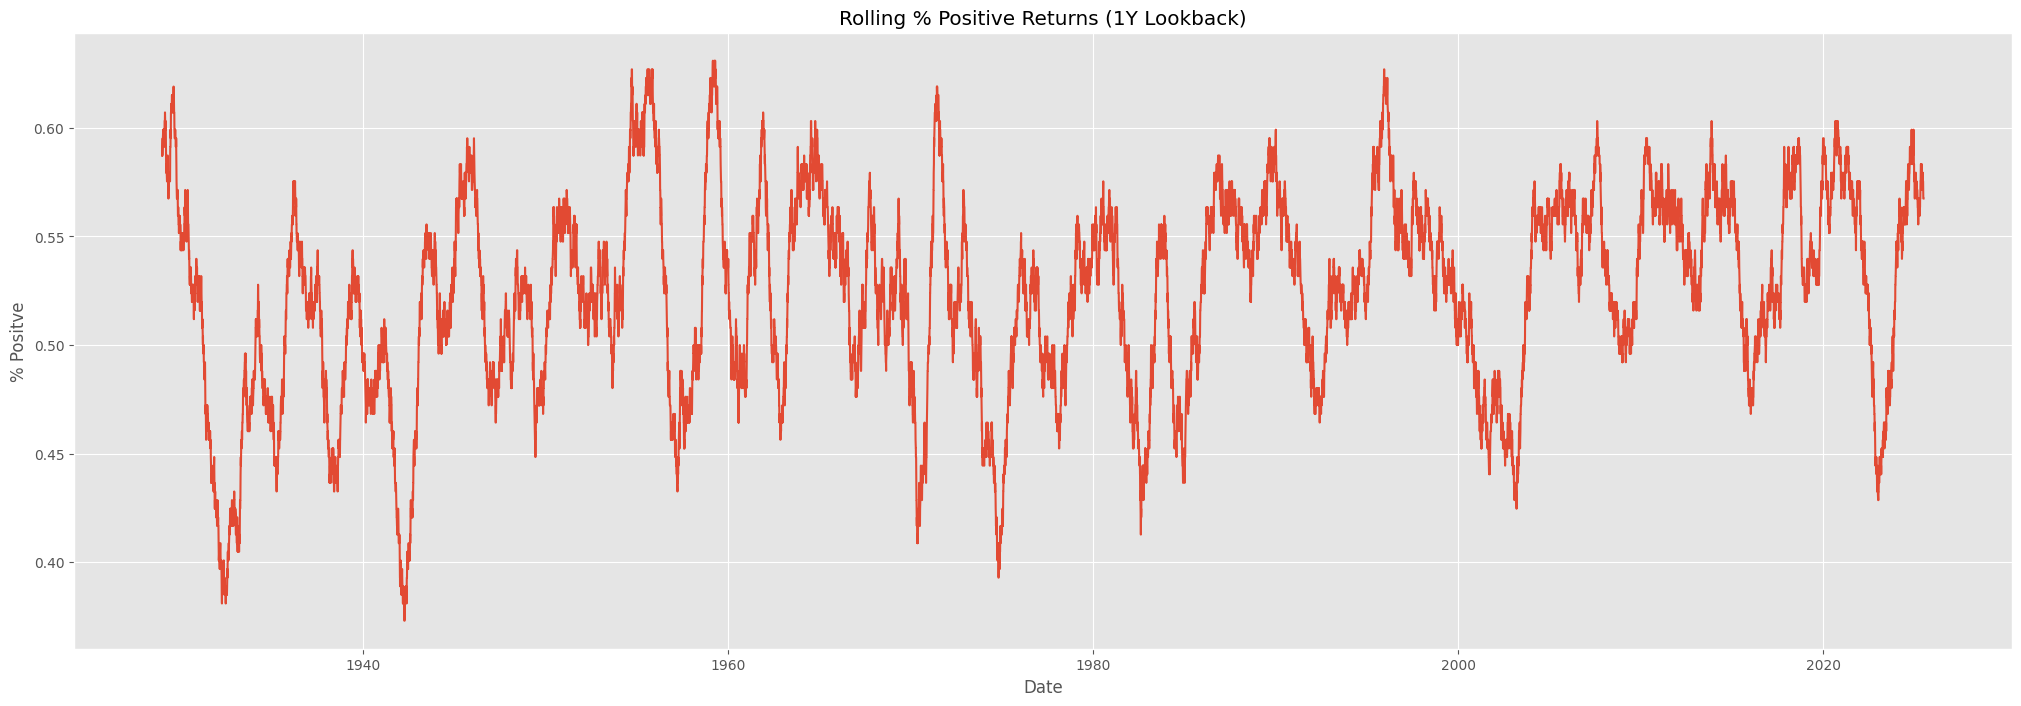

In [200]:
# Calculate the percentage of positive daily returns over a 1-year lookback period
# NOTE: This is on a rolling basis

DAILY_LOOKBACK = 252

# Identify positive (1) and negative (0) returns
positive = (data['Daily'] > 0).astype(int)
daily_pct_positive = positive.rolling(window=DAILY_LOOKBACK).mean()
daily_pct_positive.dropna(inplace=True)

mean_positive_pct = np.mean(positive)

print(f"(Daily) Minimum Positive %: {min(daily_pct_positive)*100:.4f}")
print(f"(Daily) Maximum Positive %: {max(daily_pct_positive)*100:.4f}")
print(f"(Daily) Mean Positive %:     {mean_positive_pct*100:.4f}")

plt.figure(figsize=(25, 8))
plt.plot(daily_pct_positive)
plt.title('Rolling % Positive Returns (1Y Lookback)')
plt.xlabel('Date')
plt.ylabel('% Positve')
plt.show()

#### Augmented Dickey-Fuller Test
To determine if the percentage of positive daily returns (with a 1-year lookback) is a mean-reverting process, we start by conducting the ADF test to determine if the process is stationary. A stationary process exhibits constant variance over time.<br>
Null Hypothesis(H0): The process is non-stationary; has no constant variance over time.<br>
Alt. Hypothesis(Ha): The process is stationary.

In [201]:
# To test for mean-reversion, compute the ADF Test
adf_results = sm.tsa.stattools.adfuller(daily_pct_positive)

print(adf_results[1]) # p-value of ADF test

3.33378332776753e-07


Because the p-value of the ADF test is less than 0.05, we can reject the null hypothesis and conclude that the percentage of positive daily returns is a stationary process. Because a stationary process does not imply a mean-reverting process, further tests need to be conducted. Below computes the Hurst exponent to measure the level of mean-reversion within the series.

In [202]:
H, c, data = hurst.compute_Hc(daily_pct_positive, kind='price')

print(H) #Hurst exponent

0.46593527750227515


The Hurst exponent is below 0.5, suggesting that the percentage of positive daily returns is a mean-reverting process.